# 1. Introduction
Hypertension is a medical condition that afflicts many people all around the world, this situation occurs when our pressure overcome normal levels. Let's see them next

- **Systolic**  
$$
90\ mmHg < x < 120\ mmHg
$$

- **Diastolic**
$$
60\ mmHg < x < 80\ mmHg
$$

In this case we will be working with systolic levels.

# 2. Problem Statement
Let's suppose you are a Data Analyst working for a pharmaceuitical company where you are asked to test 3 different blood pressure treatments, the task is simple, you need to decide which is the best according to the provided data. At this point you could think "I will use a hypotesis test" however, remember these ones only work for at most two samples and here you have three, What can you do? an ANOVA.

## ANOVA
ANOVA is an hypotesis test for more than 2 samples, mathematically this looks like:

$$
H_0: \mu_1=\mu_2=...=\mu_k\\
H_1: \mu_i\neq\mu_j\ :\ \ \ \ \ i\neq j
$$

The interpretation is simple:
- $H_0$: All the samples have the same mean, thus, There is no statistical evidence to affirm that one treatment is better than another.
- $H_1$: There is at least one mean different from the rest, which means that exist treatments better than others.

Our task is to determine which is the best treatment by comparation.

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sb

# Statistical tools
import scipy.stats as stats 
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Ignor warnings
import warnings
warnings.filterwarnings('ignore')

# 3. Data Riview

## Variables Description
- **Tratment**: Medicine type to study
- **RT [min]**:       Medicine response time (span from patient take the medicine until medicine actuates)
- **Pressure [mmHg]**: Patient's pressure after the medicine response time
- **Race**: Patient's race
- **Age**: Patient's age
- **Sex**: Patient's sex

In [12]:
data = pd.read_csv('C:/Users/Roberto/Desktop/datasets/hypertension.csv')
data.head()

,Treatment,Pressure,Race,Age,Sex,RT
0,B,114.046290,Black,60,Man,13.451470
1,B,108.708371,White,65,Man,13.732999
2,A,136.783010,White,66,Woman,28.403520
3,A,109.277953,Black,70,Woman,25.668797
4,C,115.325929,Hispanic,60,Woman,52.016299


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Treatment  679 non-null    object 
 1   Pressure   679 non-null    float64
 2   Race       679 non-null    object 
 3   Age        679 non-null    int64  
 4   Sex        679 non-null    object 
 5   RT         679 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 32.0+ KB


Our data seems to be clean, let's perform an exploratory data analysis to find out correlation and distributions

## Exploratory Data Analysis

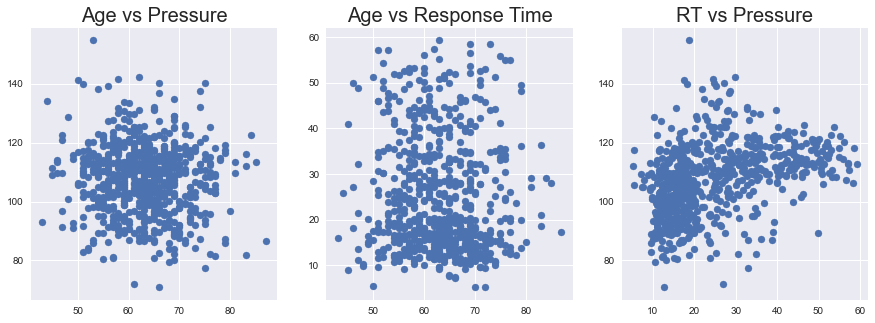

In [14]:
# Let's study correlation among numerical variables
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(data['Age'],data['Pressure'])
plt.title('Age vs Pressure', size=20)

plt.subplot(1,3,2)
plt.scatter(data['Age'],data['RT'])
plt.title('Age vs Response Time', size=20)

plt.subplot(1,3,3)
plt.scatter(data['RT'],data['Pressure'])
plt.title('RT vs Pressure', size=20)

plt.plot();

Numerical variables don't present correlation which is good if we want to implement a predictive model.

In [15]:
def graph(data):
  plt.figure(figsize=(15,15))

  plt.subplot(2,2,1)
  sb.countplot('Sex', data=data)
  plt.title('Frequency Analysis by Gender', size=20)

  plt.subplot(2,2,2)
  sb.kdeplot(data=data, x="Age", fill=True, alpha=.8, linewidth=3)
  plt.title('Age Distribution', size=20)

  plt.subplot(2,2,3)
  cantidades = data.groupby('Race').count().T.sum().tolist()
  Raza = ['Black','Hispanic','Chinese','White']
  plt.pie(cantidades,labels=Raza, shadow=True)
  plt.title('Race Proportion', size=20)

  plt.subplot(2,2,4)
  sb.boxplot(data=data, x="RT")
  plt.title('Response time', size=20)

  plt.show()

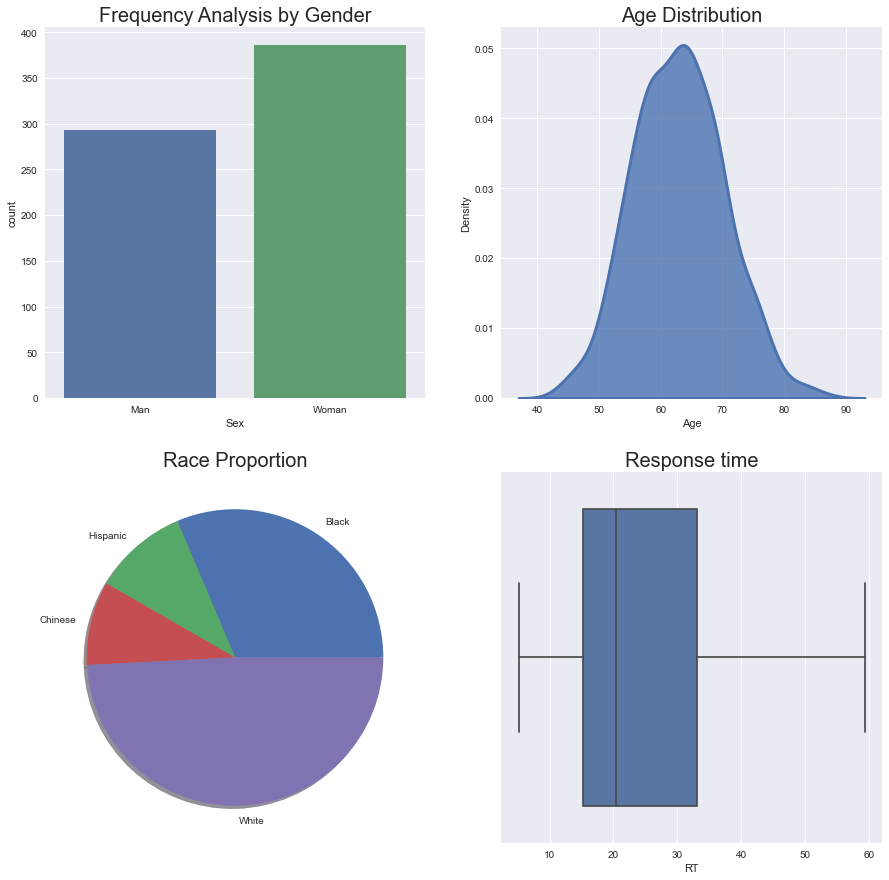

In [16]:
graph(data)

## Observations
- The sample seems to be balanced by gender
- The "Age distribution" seems to be normal
- There are significantly more whites than other race
- There are not outliers at the "Response Time" variable

All the data seems to be clean

# 4. Data Preprocessing

### Creating variables
Now we will create a new variable which contains age ranges because we will need it in the next stage.

In [17]:
# Let's set age ranges every 10 years, this ranges are: 
#   <50
# 50<x<60
# 60<x<70
# 70<x<80
#   >80

# Cutting the "Age" variable in the previously selected categories:

intervalos = [ min(data.Age) , 50 , 60, 70, 80, max(data.Age) ]
categorias = [ '<50', '[50,60]','[60,70]','[70,80]','>80']
data['Age Range'] = pd.cut(data['Age'], bins=intervalos , labels=categorias)
data.head()

,Treatment,Pressure,Race,Age,Sex,RT,Age Range
0,B,114.046290,Black,60,Man,13.451470,"[50,60]"
1,B,108.708371,White,65,Man,13.732999,"[60,70]"
2,A,136.783010,White,66,Woman,28.403520,"[60,70]"
3,A,109.277953,Black,70,Woman,25.668797,"[60,70]"
4,C,115.325929,Hispanic,60,Woman,52.016299,"[50,60]"


# 5. Statistics
In this case we have 2 incorrelated variables of interest
- Pressure
- RT (Response Time)

And 3 factores ni which we can analyze these variables
- Age
- Treatment
- Race

But remember our goal is to find the **best treatment** to deal with hypertension. In order to address this problem let's do 6 graphs where we combine all possible combinations

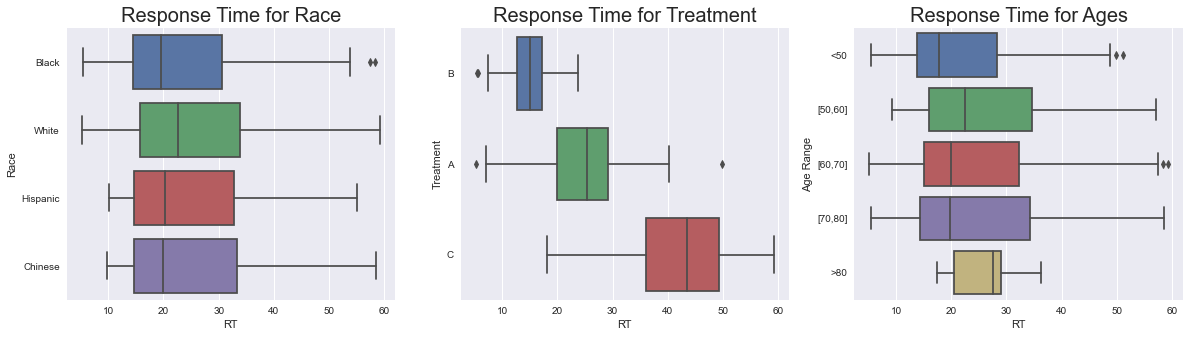

In [20]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sb.boxplot(data=data, x="RT", y='Race')
plt.title('Response Time for Race', size=20)

plt.subplot(1,3,2)
sb.boxplot(data=data, x="RT", y='Treatment')
plt.title('Response Time for Treatment', size=20)

plt.subplot(1,3,3)
sb.boxplot(data=data, x="RT", y='Age Range')
plt.title('Response Time for Ages', size=20)

plt.plot();

Response time does not seem to depend on race or age, but on treatment. Let's do the same for the "Pressure" variable

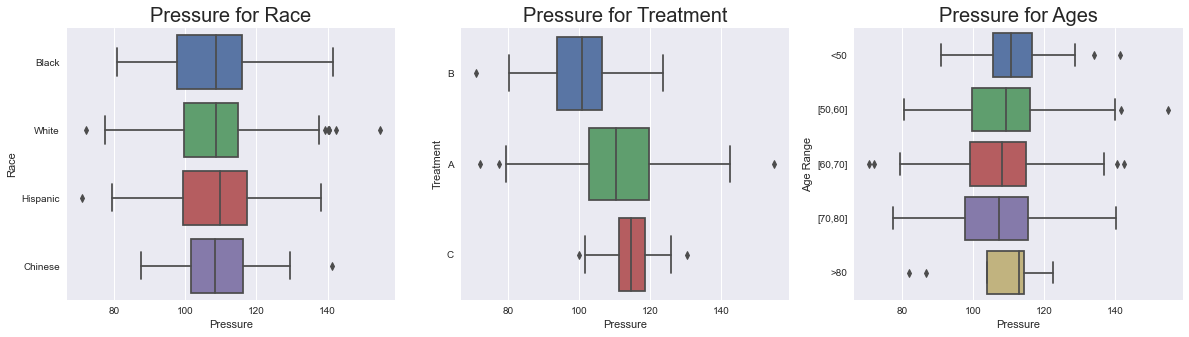

In [22]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sb.boxplot(data=data, x="Pressure", y='Race')
plt.title('Pressure for Race', size=20)

plt.subplot(1,3,2)
sb.boxplot(data=data, x="Pressure", y='Treatment')
plt.title('Pressure for Treatment', size=20)

plt.subplot(1,3,3)
sb.boxplot(data=data, x="Pressure", y='Age Range')
plt.title('Pressure for Ages', size=20)

plt.plot();

We obtain a similar result, the only variable where pressure changes is "Treatment". Let's now study these two separately

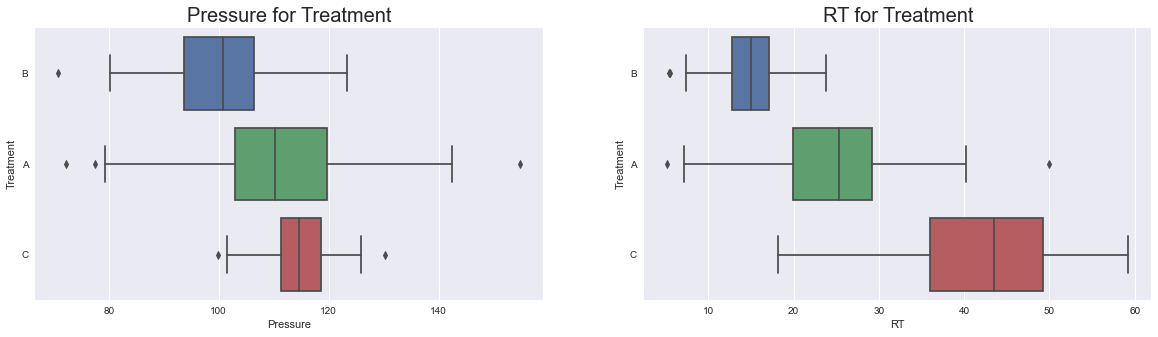

In [25]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sb.boxplot(data=data, x="Pressure", y='Treatment')
plt.title('Pressure for Treatment', size=20)

plt.subplot(1,2,2)
sb.boxplot(data=data, x="RT", y='Treatment')
plt.title('RT for Treatment', size=20)

plt.plot();

- From previous graphs we can clarely see that **treatment B** actuates before than **treatment A** which in turns actuates before than **treatment C**.
- The variable **pressure for treatment** has a similar behaivior but the gap between boxplots is not as big as last case, so we need to perfom an ANOVA to check whether these means are really different or not.

In [26]:
# To perform the ANOVA we first need to cut the variable "Pressure" by the levels of the variable "Treatment"
# We will do this using the "groupby function"
groups = data.groupby('Treatment').groups
A = data.Pressure[groups['A']]
B = data.Pressure[groups['B']]
C = data.Pressure[groups['C']]

## ANOVA for mean pressure
$$
H_0: \hat{p}_A=\hat{p}_B=\hat{p}_C\ \ \ \ \rightarrow \ \ \ \  p_{val}\geq 0.05\\ \
H_1: \hat{p}_A\neq\hat{p}_B\ \neq \hat{p}_C \ \ \ \ \ \rightarrow \ \ \ \  p_{val}<0.05
$$

In [27]:
# Hacemos el contraste ANOVA
pval = stats.f_oneway(A,B,C)[1]
print('p-val:',pval)

p-val: 5.923631446122182e-45


The hypotesis test at 5% of confidence provides evidence to afirm that at least two means are different, let's find them!

In [29]:
tukey = pairwise_tukeyhsd(endog=data['Pressure'],
                          groups=data['Treatment'],
                          alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,-10.6948,0.001,-12.8656,-8.524,True
A,C,3.7384,0.0015,1.2274,6.2494,True
B,C,14.4332,0.001,12.0127,16.8536,True


The Tyckey test shows that all the means are different, just as we expected when looking at the plots!

# 6. Results

## What is the most effective treatment?

Numerical values from previos plots:

|Feature \ Treatment | A | B | C | 
|:-------------:|:--:|:--:|:--:|
|**Pressure [mmHg]**   | 110 | 100 | 115  | 
|**RT [min]**         | 25 | 15 | 45  | 

\\
Dispresion per treatment

| $\sigma$ | A | B | C | 
|:-------------:|:--:|:--:|:--:|
|**Pressure [mmHg]**   | 15 | 10 | 5  | 
|**RT [min]**         | 7 | 3 | 10  | 

\\

Summary 

|Feature \ Treatment | A | B | C |
|:-------------:|:--:|:--:|:--:|
|**Pressure**   |medium | smallest |  highest  |
|**RT**         | medium | fastest |  slowest  |

\

- **A** : Get pressure at **110 mmHg** ($\sigma_p=15$), actuates past **~25 min** ($\sigma_t$=7)
- **B** : Set pressure at **100 mmHg** ($\sigma_p=10$), **~15 min** after consumed ($\sigma_t$=3)
- **C** : Stablish pressure at **115 mmHg** ($\sigma_p=5$) after **~45 min** ($\sigma_t$=10)

. 
# 7. Conclusion
Since all of the treatments mantein systolic presure within acceptable levels we must choose **treatment B** for being the fastest and lest dispersed. 

**What does this means?** this means that if you suffer of hypertension you can take **treatment B** and your pressure will get at 100 mmHg after ~ 15 minutes.